Testing Accuracy: 0.982


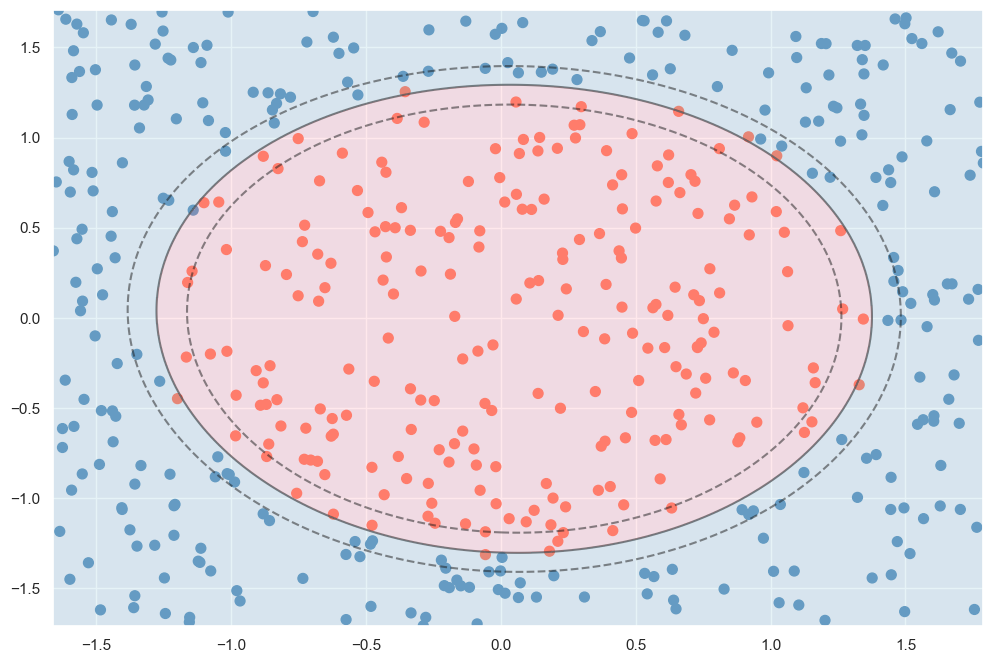

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns; sns.set()
import torch

data = torch.load('exercise2.pt')
data = data.T
X = data[:, :-1]  # all rows & all columns except for the last one
y = data[:, -1]

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


class NonLinearSVM:
    def __init__(self, C, max_iter, gamma, learning_rate):
        self.kernel = self.rbf_kernel
        self.C = C
        self.max_iter = max_iter
        self.gamma = gamma  # for rbf kernel
        self.lr = learning_rate

    def rbf_kernel(self, x_i, x_j):
        return np.exp(-self.gamma * np.sum((x_j - x_i[:, np.newaxis]) ** 2, axis=-1))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        self.y[self.y == 0] = -1

        self.alpha = np.zeros(n_samples)  # Lagrange multipliers
        self.b = 0

        # compute kernel matrix with each K_ij represents the kernel function value between x_i and x_j
        K = self.kernel(X, X)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                condition = y[i] * (np.sum(self.alpha * y * K[:, i]) + self.b) >= 1
                if condition:  # correctly classified
                    self.alpha[i] -= self.lr * (2 * self.alpha[i])
                else:  # not correctly classified
                    self.alpha[i] += self.lr * (1 - y[i] * (np.sum(self.alpha * y * K[:, i]) + self.b))
                    self.b += self.lr * y[i]

                # constraints
                self.alpha[i] = np.clip(self.alpha[i], 0, self.C)

            self.b -= self.lr * (np.sum(self.alpha * y) / n_samples)

    def decision_function(self, X):
        K = self.kernel(X, self.X)
        return np.sum(self.alpha * self.y * K, axis=1) + self.b

    def predict(self, X):
        prediction = (np.sign(self.decision_function(X)) + 1) // 2
        return prediction


def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

def test_plot(X_train, y_train, X_test, y_test, svm_model, axes):
    plt.axes(axes)
    xlim = [np.min(X_train[:, 0]), np.max(X_train[:, 0])]
    ylim = [np.min(X_train[:, 1]), np.max(X_train[:, 1])]
    xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
    rgb = np.array([[210, 0, 0], [0, 0, 150]]) / 255.0

    z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap=ListedColormap(['#FF6347', '#4682B4']))
    plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(['#FFB6C1', '#ADD8E6']), zorder=1)


# Train
svm = NonLinearSVM(C=10, max_iter=1000, gamma=0.1, learning_rate=0.01)
svm.fit(X_train, y_train)


# Predict
y_test_pred = svm.predict(X_test)
accuracy_test = calculate_accuracy(y_test, y_test_pred)
print("Testing Accuracy:", accuracy_test)


# Plot
fig, axs = plt.subplots(figsize=(12, 8))
test_plot(X_train, y_train, X_test, y_test, svm, axs)
